In [1]:
#It imports the required libraries, including pandas, torch, torch.utils.data, torch.nn, torch.optim, numpy, and spacy.
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
import random
import wandb
wandb.login(key='e595ff5b95c353a42c4bd1f35b70856d4309ef00')

#It defines the device to be used for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths for the train, validation, and test data
train_data_path = "/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_train.csv"
valid_data_path = "/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_valid.csv"
test_data_path = "/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_test.csv"

#It defines the SOS (Start of Sequence), EOS (End of Sequence), PAD (Padding), and UNK (Unknown) tokens.
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

#It defines a class called VocabDataset to handle vocabulary creation and mapping of characters to indices.
#Inside the VocabDataset class, the constructor initializes the vocabulary dictionaries and sets the vocabulary sizes.
#It creates character-to-index and index-to-character mappings for the source and target characters, including the SOS, EOS, PAD, and UNK tokens.
#It iterates over the source and target words in the data to populate the vocabulary dictionaries with unique characters.
class VocabDataset:
    def __init__(self, data):
        self.data = data
        self.max_seq_len = max(self.data['source'].apply(len))
        self.source_char_to_idx = {}
        self.source_idx_to_char = {}
        self.source_vocab_size = 0
        

        # Add SOS and EOS tokens to the source character dictionary
        self.source_char_to_idx[SOS_TOKEN] = self.source_vocab_size
        self.source_idx_to_char[self.source_vocab_size] = SOS_TOKEN
        self.source_vocab_size += 1

        self.source_char_to_idx[EOS_TOKEN] = self.source_vocab_size
        self.source_idx_to_char[self.source_vocab_size] = EOS_TOKEN
        self.source_vocab_size += 1
        
        self.source_char_to_idx[PAD_TOKEN] = self.source_vocab_size
        self.source_idx_to_char[self.source_vocab_size]= PAD_TOKEN
        self.source_vocab_size += 1
        
        self.source_char_to_idx[UNK_TOKEN] = self.source_vocab_size
        self.source_idx_to_char[self.source_vocab_size] = UNK_TOKEN
        self.source_vocab_size += 1
        


        self.target_char_to_idx = {}
        self.target_idx_to_char = {}
        self.target_vocab_size = 0
        

        # Add SOS and EOS tokens to the target character dictionary
        self.target_char_to_idx[SOS_TOKEN] = self.target_vocab_size
        self.target_idx_to_char[self.target_vocab_size] = SOS_TOKEN
        self.target_vocab_size += 1

        self.target_char_to_idx[EOS_TOKEN] = self.target_vocab_size
        self.target_idx_to_char[self.target_vocab_size] = EOS_TOKEN
        self.target_vocab_size += 1
        
        self.target_char_to_idx[PAD_TOKEN] = self.source_vocab_size
        self.target_idx_to_char[self.source_vocab_size]= PAD_TOKEN
        self.target_vocab_size += 1
        
        self.target_char_to_idx[UNK_TOKEN] = self.target_vocab_size
        self.target_idx_to_char[self.target_vocab_size] = UNK_TOKEN
        self.target_vocab_size += 1


        # Create character to index and index to character mappings for source and target
        for word in self.data['source']:
            for char in word:
                if char not in self.source_char_to_idx:
                    self.source_char_to_idx[char] = self.source_vocab_size
                    self.source_idx_to_char[self.source_vocab_size] = char
                    self.source_vocab_size += 1


        for word in self.data['target']:
            for char in word:
                if char not in self.target_char_to_idx:
                    self.target_char_to_idx[char] = self.target_vocab_size
                    self.target_idx_to_char[self.target_vocab_size] = char
                    self.target_vocab_size += 1
        
        #self.source_char_to_idx[self.SOS_TOKEN]
        
#It defines a function called transliterationDataset to preprocess the data and convert it into tensors.
#Inside the transliterationDataset function, the source and target words are converted into sequences of character indices using the vocabulary mappings. Special tokens are added to the target sequences (SOS and EOS).
#The preprocessed data is then returned as a list of tuples, where each tuple contains the source and target sequences as tensors.
def transliterationDataset(data, vocab):
    data['source'] = data['source'].apply(lambda x: [] + 
                                                    [vocab.source_char_to_idx[char] if char in vocab.source_char_to_idx else vocab.source_char_to_idx[UNK_TOKEN] for char in x] + 
                                                    [vocab.source_char_to_idx[EOS_TOKEN]])

    data['target'] = data['target'].apply(lambda x: [vocab.target_char_to_idx[SOS_TOKEN]] + 
                                                    [vocab.target_char_to_idx[char] if char in vocab.target_char_to_idx else vocab.target_char_to_idx[UNK_TOKEN] for char in x] + 
                                                    [vocab.target_char_to_idx[EOS_TOKEN]])
    new_data = []
    for i in range(data.shape[0]):
        source_data = data.iloc[i]['source']
        target_data = data.iloc[i]['target']
        source_data = torch.tensor(source_data)
        target_data = torch.tensor(target_data)
        new_data.append((source_data, target_data))
    return new_data


#It reads the training, validation, and test data from CSV files into pandas dataframes.
train_data = pd.read_csv(train_data_path,names=['source', 'target'])
valid_data = pd.read_csv(valid_data_path,names=['source', 'target'])
test_data = pd.read_csv(test_data_path,names=['source', 'target'])

#It creates an instance of the VocabDataset class using the training data, which initializes the vocabulary mappings.
vocab = VocabDataset(train_data)

# Create the train, validation, and test datasets
#It calls the transliterationDataset function to preprocess the training, validation, and test data using the created vocabulary.
train_dataset = transliterationDataset(train_data, vocab)
valid_dataset = transliterationDataset(valid_data, vocab)
test_dataset = transliterationDataset(test_data, vocab)


input_characters = list(vocab.source_char_to_idx.keys())
output_characters = list(vocab.target_char_to_idx.keys())

#It defines the collate_fn function, which is used as the collate_fn argument in the DataLoader to pad the sequences in each batch.
def collate_fn(batch):
    source_sequences, target_sequences = zip(*batch)
    source_sequences_padded = pad_sequence(source_sequences, batch_first=False, padding_value=2)
    target_sequences_padded = pad_sequence(target_sequences, batch_first=False, padding_value=2)
    return source_sequences_padded, target_sequences_padded

# Create the train, validation, and test dataloaders
#It defines the create_dataloader function, which creates and returns the train, validation, and test dataloaders.
def create_dataloader(batch_size):
    batch_size = 9
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size,collate_fn=collate_fn)
    
    return train_dataloader,valid_dataloader,test_dataloader

# print(train_dataset.target_char_to_idx)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:

#Defines a class named Encoder that extends nn.Module for the encoder component of the sequence-to-sequence model
class Encoder(nn.Module):
    #Initializes the encoder with the given parameters: input_size, embedding_size, hidden_size, num_layers, p (dropout rate), bidirectional (default: False), and cell_type (default: LSTM).
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, bidirectional=False, cell_type='LSTM'):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p) #Creates an instance variable dropout to apply dropout regularization
        #Sets other instance variables for the hidden size, number of layers, bidirectionality, and cell type of the encoder.
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.cell_type = cell_type
        
        #Initializes an embedding layer with the given input_size and embedding_size.
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        #Creates the recurrent neural network (RNN) layer based on the selected cell_type (RNN, GRU, LSTM).
        if cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=p, bidirectional=bidirectional)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=p, bidirectional=bidirectional)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, bidirectional=bidirectional)
        else:
            #Raises a ValueError if the given cell_type is not supported.
            raise ValueError(f"Invalid cell type: {cell_type}. Supported cell types: RNN, GRU, LSTM")

    #Implements the forward pass of the encoder.
    def forward(self, x):
        #Applies dropout to the embedded input sequence (x) using self.dropout.
        embedding = self.dropout(self.embedding(x))
        
        outputs, hidden = self.rnn(embedding)#Passes the embedded input through the RNN layer (self.rnn) to obtain the outputs and hidden state.
        
        #If the cell type is LSTM, extracts the cell state from the hidden state and returns the outputs, hidden state, and cell state.
        if self.cell_type == 'LSTM':
            cell = hidden[1]
            hidden = hidden[0]
            return outputs,hidden, cell
        else:
            #If the cell type is not LSTM, returns the outputs and hidden state.
            return outputs,hidden

#Defines a class named Attention that extends nn.Module for implementing the attention mechanism.
class Attention(nn.Module):
    #Initializes the attention mechanism with the given hidden_size.
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        #Creates two linear layers: self.attn with input size hidden_size * 2 and output size hidden_size, and self.v with input size hidden_size and output size 1.
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size, bias=False)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        
    #Implements the forward pass of the attention mechanism.
    #Obtains the maximum sequence length (max_len) and batch size (batch_size) from the encoder_outputs tensor.
    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)

        # Repeat hidden state to match the shape of encoder_outputs
        hidden = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        #Transposes the encoder_outputs tensor.
        encoder_outputs = encoder_outputs.transpose(0, 1)
        
        #Concatenates the hidden and encoder_outputs tensors along the last dimension (dim=2).
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        #Passes the concatenated tensor through the linear layer self.attn followed by a tanh activation function to compute the energy.
        #Passes the energy tensor through the linear layer self.v to obtain attention scores.
        attention_scores = self.v(energy)
        attention_weights = torch.softmax(attention_scores, dim=1)
        #Returns the attention weights tensor, but with dimensions permuted to have shape (batch_size, 1, max_len).
        return attention_weights.permute(2,0,1)

#Defines a class named Decoder that extends nn.Module for implementing the decoder.
class Decoder(nn.Module):
    #Initializes the decoder with the given input_size, embedding_size, hidden_size, output_size, num_layers, p (dropout rate), and cell_type.
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p, cell_type='LSTM'
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        #Creates an embedding layer self.embedding with input size input_size and embedding size embedding_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        #Based on the cell_type value, selects the appropriate RNN cell (RNN, GRU, or LSTM) and assigns it to self.rnn.
        if cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size + hidden_size, hidden_size, num_layers, dropout=p)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size + hidden_size, hidden_size, num_layers, dropout=p)
        elif cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers, dropout=p)
        else:
            raise ValueError(f"Invalid cell type: {cell_type}. Supported cell types: RNN, GRU, LSTM")
        #Creates an instance of the Attention class and assigns it to self.attention
        self.attention = Attention(hidden_size)
        #Creates a linear layer self.fc with input size hidden_size and output size output_size.
        self.fc = nn.Linear(hidden_size, output_size)
        
    #Implements the forward pass of the decoder.
    def forward(self, x, hidden, encoder_outputs, cell=None):
        #Unsqueezes the input tensor x to add a dimension of size 1 at index 0.
        x = x.unsqueeze(0)
        #Passes the unsqueezed tensor through the embedding layer self.embedding and applies dropout to obtain the embedded input tensor.
        embedding = self.dropout(self.embedding(x))

        # Apply attention mechanism
        #Computes the attention weights by passing the last hidden state tensor (hidden[-1:]) and encoder_outputs through the attention mechanism.
        attention_weights = self.attention(hidden[-1:], encoder_outputs)
        #Computes the context vector by performing matrix multiplication between the transposed attention weights and the transposed encoder outputs.
        context = attention_weights.permute(1,0,2) @ encoder_outputs.permute(1,0,2)
        #Permute the dimensions of context tensor to have shape (1, batch_size, hidden_size).
        context=context.permute(1,0,2)

        # Combine embedded input word and context vector
        #Concatenates the embedded input tensor and the context vector along the last dimension (dim=2) to create the input for the RNN.
        rnn_input = torch.cat((embedding, context), dim=2)
        #Passes the concatenated input tensor rnn_input through the RNN.
        #If the cell_type is LSTM, the RNN returns both the output tensor (outputs) and a tuple of hidden and cell states. Otherwise, it returns only the output tensor and the hidden state.
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        else:
            #Updates the hidden and cell states with the new values.
            outputs, hidden = self.rnn(rnn_input, hidden)
        #Squeezes the first dimension of the output tensor outputs to remove the sequence length of 1.
        #Passes the squeezed tensor through the linear layer self.fc to obtain the predictions.
        predictions = self.fc(outputs.squeeze(0))
        #If the cell_type is LSTM, returns the predictions, updated hidden and cell states, and the attention weights.
        if self.cell_type == 'LSTM':
            return predictions, hidden, cell, attention_weights
        else:
            #If the cell_type is not LSTM, returns the predictions, updated hidden state, and the attention weights.
            return predictions, hidden, attention_weights

#Defines a class named Seq2Seq that extends nn.Module for implementing the sequence-to-sequence model.
class Seq2Seq(nn.Module):
    #Initializes the Seq2Seq model with an encoder and decoder passed as arguments.
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        #Assigns the encoder and decoder to instance variables self.encoder and self.decoder.
        self.encoder = encoder
        self.decoder = decoder
        
        #Copies the bidirectional and num_layers properties from the encoder to the Seq2Seq model.
        self.bidirectional = self.encoder.bidirectional
        self.num_layers = self.encoder.num_layers
    #Implements the forward pass of the Seq2Seq model.
    def forward(self, source, target, teacher_force_ratio=0.5):
        #Retrieves the dimensions and sizes of the source and target tensors.
        batch_size = source.shape[1]
        source_len = source.shape[0]
        target_len = target.shape[0]
        target_vocab_size = len(output_characters)
        #Creates zero-filled tensors for outputs and attn_m with appropriate dimensions and moves them to the device (assumed to be defined earlier).
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        attn_m = torch.zeros(target_len, batch_size, source_len).to(device)
        
        #Passes the source tensor through the encoder
        #If the decoder's cell type is LSTM, receives outputs1, hidden, and cell from the encoder.
        if self.decoder.cell_type == 'LSTM':
            outputs1,hidden, cell = self.encoder(source)
        else:
            #Otherwise, receives outputs1 and hidden from the encoder, and sets cell to None
            outputs1,hidden = self.encoder(source)
            cell = None
            
        #If the encoder is bidirectional, reshapes the hidden state tensor and applies sum operation along the second dimension (direction) to merge the bidirectional states.
        # Reshape the hidden state from the encoder to match the decoder's expected shape
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, batch_size, -1).sum(1)
            
            #Updates outputs1 to split the bidirectional output tensor into forward and backward states.
            outputs1 = outputs1[:,:,:self.encoder.hidden_size] + outputs1[:,:,self.encoder.hidden_size:]
            #If the decoder's cell type is LSTM, reshapes the cell state tensor and applies sum operation along the second dimension.
            if self.decoder.cell_type == 'LSTM':
                cell = cell.view(self.num_layers, 2, batch_size, -1).sum(1)
                
        #Selects the last layer's hidden state and updates its shape to match the decoder's expected shape.
        hidden = hidden[-1]
        hidden = hidden.unsqueeze(0)
        hidden = hidden.repeat(self.decoder.num_layers, 1, 1)
        #If the decoder's cell type is LSTM, selects the last layer's cell state and updates its shape to match the decoder's expected shape.
        if self.decoder.cell_type == 'LSTM':
            cell = cell[-1]
            cell = cell.unsqueeze(0)
            cell = cell.repeat(self.decoder.num_layers, 1, 1)
            
        #Initializes x with the first token of the target sequence.
        x = target[0]
        #Iterates over each time step in the target sequence.
        for t in range(1, target_len):
            #If the decoder's cell type is LSTM, passes x, hidden, outputs1, and cell to the decoder and receives output, updated hidden, cell, and attn_wt.
            if self.decoder.cell_type == 'LSTM':
                output, hidden, cell, attn_wt = self.decoder(x, hidden, outputs1, cell)
            else:
                #If the decoder's cell type is not LSTM, passes x, hidden, and outputs1 to the decoder and receives output, updated hidden, and attn_wt.
                output, hidden, attn_wt = self.decoder(x, hidden, outputs1)
            #Assigns the output tensor and attention weights to the corresponding positions in outputs and attn_m.
            outputs[t] = output
            attn_m[t] = attn_wt
            #Generates the best guess for the next input token based on the output tensor.
            best_guess = output.argmax(1)
            #Updates x with the next target token if teacher_force_ratio condition is satisfied, otherwise uses the best guess.
            x = target[t] if random.random() < teacher_force_ratio else best_guess
        #Returns the outputs tensor and attention weights attn_m
        return outputs, attn_m


In [3]:
def calculate_number_equal_words(prediction,target):
    # Compute the number of equal words between the prediction and target sequences
    # Count the columns where either the prediction is equal to the target or the target is a padding token (value 2)
    num_equal_columns = torch.logical_or(prediction == target,target==2).all(dim=0).sum().item()
    return num_equal_columns

In [4]:

# Training hyperparameters
num_epochs = 15
learning_rate = 0.001
batch_size = 9
train_dataloader,valid_dataloader,test_dataloader=create_dataloader(batch_size)
input_size_encoder = len(input_characters)
input_size_decoder = len(output_characters)
output_size = len(output_characters)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model hyperparameters starts
embedding_size = 64
encoder_num_layers = 1
decoder_num_layers = 2
hidden_layer_size = 256  # Needs to be the same for both RNN's
enc_dropout = 0.2
dec_dropout = 0.2
cell_type= "LSTM"
bidirectional=True
# Model hyperparameters ends
#It defines and initializes the encoder network using the Encoder class, which takes input size, embedding size, hidden layer size, number of layers, dropout rate, bidirectional flag, and cell type (RNN, GRU, or LSTM) as arguments.
encoder_net = Encoder(
    input_size_encoder, embedding_size, hidden_layer_size, encoder_num_layers, 
    enc_dropout,bidirectional,cell_type).to(device)
#It defines and initializes the decoder network using the Decoder class, which takes input size, embedding size, hidden layer size, output size, number of layers, dropout rate, and cell type as arguments.
decoder_net = Decoder(input_size_decoder,embedding_size,
                      hidden_layer_size,output_size,
                      decoder_num_layers,dec_dropout,cell_type).to(device)
#It creates an instance of the sequence-to-sequence model (Seq2Seq) by passing the encoder and decoder networks as arguments.
model = Seq2Seq(encoder_net, decoder_net).to(device)
#It initializes the optimizer (Adam) with the model parameters and a learning rate.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#It defines the loss function (CrossEntropyLoss) to be used for training the model.
criterion = nn.CrossEntropyLoss()

# %% [code] {"execution":{"iopub.status.busy":"2023-05-19T18:02:20.104473Z","iopub.execute_input":"2023-05-19T18:02:20.104822Z","iopub.status.idle":"2023-05-19T18:04:05.259544Z","shell.execute_reply.started":"2023-05-19T18:02:20.104789Z","shell.execute_reply":"2023-05-19T18:04:05.258664Z"}}
min_val_loss=0
max_val_acc=0
min_train_loss=0
max_train_acc=0
min_test_loss=0
max_test_acc=0
for epoch in range(num_epochs):
    print(f"[Epoch {epoch+1} / {num_epochs}]")
    model.train()
    for i, (input_seq, target_seq) in enumerate(train_dataloader):
        inp_data = input_seq.to(device)
        tar = target_seq.to(device)

        # Forward prop
        outputs,attention_weight = model(inp_data, tar)

        output = outputs[1:].reshape(-1, outputs.shape[2])
        target = tar[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # Gradient descent step
        optimizer.step()
        
        
    #loss and accuracy of train data starts  
    total_train_loss = 0
    total_train_correct = 0
    total_train_data = 0
    model.eval()
    with torch.no_grad():
        for i, (input_seq, target_seq) in enumerate(train_dataloader):
            inp_data = input_seq.to(device)
            tar = target_seq.to(device)

            # Forward prop
            outputs,attention_weight = model(inp_data, tar)
            output = outputs[1:].reshape(-1, outputs.shape[2])
            target = tar[1:].reshape(-1)
            loss = criterion(output, target)
            total_train_loss += loss.item()

            # Calculate accuracy, excluding padding tokens
            preds = outputs.argmax(dim=2)
            correct=calculate_number_equal_words(preds,tar)
            total_train_correct += correct
            total_train_data += tar.shape[1]
        
    Train_loss=total_train_loss/len(train_dataloader)
    Train_acc=100*(total_train_correct/total_train_data)

    
    #loss and accuracy of validation data sart-----------------------------------------------
    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_examples = 0
    with torch.no_grad():
        for i, (input_seq, target_seq) in enumerate(valid_dataloader):
            inp_data = input_seq.to(device)
            tar = target_seq.to(device)
        
            # Forward prop
            outputs,attention_weight = model(inp_data, tar, teacher_force_ratio=0.0)
    
            output = outputs[1:].reshape(-1, outputs.shape[2])
            target = tar[1:].reshape(-1)

            loss = criterion(output, target)

            total_val_loss += loss.item()

            # Calculate accuracy, excluding padding tokens
            preds = outputs.argmax(dim=2)
            correct=calculate_number_equal_words(preds,tar)
#             correct = (preds == tar).all(axis=1).sum().item()
            total_correct += correct
            total_examples += tar.shape[1]

    val_loss = total_val_loss / len(valid_dataloader)
    val_acc = 100*(total_correct / total_examples)

    model.eval()
    total_test_loss = 0
    total_correct = 0
    total_examples = 0
    with torch.no_grad():
        for i, (input_seq, target_seq) in enumerate(test_dataloader):
            inp_data = input_seq.to(device)
            tar = target_seq.to(device)
        
            # Forward prop
            outputs,attention_weight = model(inp_data, tar, teacher_force_ratio=0.0)
    
            output = outputs[1:].reshape(-1, outputs.shape[2])
            target = tar[1:].reshape(-1)

            loss = criterion(output, target)

            total_test_loss += loss.item()

            # Calculate accuracy, excluding padding tokens
            preds = outputs.argmax(dim=2)
            correct=calculate_number_equal_words(preds,tar)
            total_correct += correct
            total_examples += tar.shape[1]

    test_loss = total_test_loss / len(test_dataloader)
    test_acc = 100*(total_correct / total_examples)

    if(val_acc>max_val_acc):
        max_val_acc=val_acc
        min_val_loss=val_loss
    if(Train_acc>max_train_acc):
        max_train_acc=Train_acc
        min_train_loss=Train_loss
    if(test_acc>max_test_acc):
        max_test_acc=test_acc
        min_test_loss=test_loss
    if(epoch==num_epochs-1):
        val_acc=max_val_acc
        val_loss=min_val_loss
        Train_acc=max_train_acc
        Train_loss=min_train_loss
        test_loss=min_test_loss
        test_acc=max_test_acc
    
    print("epoch",epoch+1)
    print('Training Loss: {:.6f} \t Training Accuracy: {:.6f}'.format(Train_loss, Train_acc))
    print('Validation Loss: {:.6f} \t Validation Accuracy: {:.6f}'.format(val_loss, val_acc))
    print('Test Loss: {:.6f} \t Test Accuracy: {:.6f}'.format(test_loss, test_acc))
    
#     wandb.log({'train loss':Train_loss,'train accuracy':Train_acc,'valid loss':val_loss,'valid accuracy':val_acc})


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[Epoch 1 / 15]
epoch 1
Training Loss: 0.527966 	 Training Accuracy: 27.421875
Validation Loss: 0.897806 	 Validation Accuracy: 29.907227
Test Loss: 0.932887 	 Test Accuracy: 28.564453
[Epoch 2 / 15]
epoch 2
Training Loss: 0.429996 	 Training Accuracy: 34.976562
Validation Loss: 0.872132 	 Validation Accuracy: 34.448242
Test Loss: 0.914881 	 Test Accuracy: 33.129883
[Epoch 3 / 15]
epoch 3
Training Loss: 0.387652 	 Training Accuracy: 38.650391
Validation Loss: 0.814017 	 Validation Accuracy: 35.961914
Test Loss: 0.859075 	 Test Accuracy: 35.009766
[Epoch 4 / 15]
epoch 4
Training Loss: 0.356183 	 Training Accuracy: 41.681641
Validation Loss: 0.762131 	 Validation Accuracy: 38.403320
Test Loss: 0.822802 	 Test Accuracy: 35.693359
[Epoch 5 / 15]
epoch 5
Training Loss: 0.331007 	 Training Accuracy: 43.583984
Validation Loss: 0.771630 	 Validation Accuracy: 38.745117
Test Loss: 0.830752 	 Test Accuracy: 36.596680
[Epoch 6 / 15]
epoch 6
Training Loss: 0.317358 	 Training Accuracy: 45.472656
Va

In [11]:

# from tabulate import tabulate
# from termcolor import colored
# from termcolor import colored
# from tabulate import tabulate
# import wandb
# from IPython.display import display, HTML

# #It imports the csv module to handle CSV file operations.
# import csv
# #It defines a function write_data_to_csv that takes a list of prediction data and a file path as arguments. This function writes the prediction data to a CSV file. The column names are predefined as "Source," "Target," and "Predicted.
# def write_data_to_csv(pred_data_list, file_path):
#     # Define column names
#     columns = ["Source", "Target", "Predicted"]

#     with open(file_path, mode='w', newline='') as csv_file:
#         writer = csv.DictWriter(csv_file, fieldnames=columns)
        
#         # Write the column headers
#         writer.writeheader()

#         # Write data row by row
#         for data in pred_data_list:
#             writer.writerow(data)
# #The code initializes an empty list pred_data_list to store the prediction data.
# pred_data_list=[]
# from Levenshtein import distance
# grid_data_list=[]
# from Levenshtein import distance
# #The model is put in evaluation mode using model.eval().

# model.eval()
# #The code enters a torch.no_grad() context to disable gradient computation during inference.
# with torch.no_grad():
#     #It iterates over the test data batches from test_dataloader
#     for i, (input_seq, target_seq) in enumerate(test_dataloader):
#         #Input sequences (input_seq) and target sequences (target_seq) are moved to the appropriate device (device).
#         inp_data = input_seq.to(device)
#         tar = target_seq.to(device)

#         # Forward prop
#         #The model is called with the input sequences and target sequences to obtain the outputs (outputs) and attention weights (attention_weight).
#         outputs,attention_weight = model(inp_data, tar)
#         #The predictions (preds) are obtained by taking the argmax along the third dimension (sequence length).
#         preds = outputs.argmax(dim=2)

#         #For each example in the batch, the input word, target word, and prediction word are constructed by mapping the indices to characters using the vocabulary (vocab). The characters are concatenated to form the words.
#         for idx in range(batch_size):
#             prediction_word=""
#             target_word=""
#             input_word=""
#             for c in inp_data[:,idx]:
#                 if(c>2):
#                     input_word+=vocab.source_idx_to_char[c.item()]
#             for c in preds[:,idx]:
#                 if(c>2):
#                     prediction_word+=vocab.target_idx_to_char[c.item()]
#             for c in tar[:,idx]:
#                 if(c>2):
#                     target_word+=vocab.target_idx_to_char[c.item()]
#             #The constructed data ({"Source": input_word, "Target": target_word, "Predicted": prediction_word}) is appended to the pred_data_list.
#             pred_data_list.append({"Source": input_word, "Target": target_word, "Predicted": prediction_word})
#             if(i==0 and idx<10):
#                 levenshtein_distance = distance(prediction_word, target_word)
#                 grid_data_list.append([input_word,target_word,prediction_word,str(levenshtein_distance)])
            


# #An output file path is defined.
# output_file_path = "/kaggle/working/predictions_vanilla_file.csv"
# #The function write_data_to_csv is called to write the pred_data_list to a CSV file at the specified output file path.
# write_data_to_csv(pred_data_list, output_file_path)

# # Define the color mappings for each column
# color_mappings = {
#     0: 'cyan',  # Source column
#     1: 'magenta',  # Target column
#     2: 'orange',  # Predicted column
#     3: 'red'  # Levenshtein Distance column
# }

# # Create a formatted table string with colored cells and row/column lines
# table_string = "<table style='border-collapse: collapse;'>"
# # Header row
# table_string += "<tr style='border-bottom: 1px solid black;'>"
# table_string += "<th style='padding: 8px; text-align: left; background-color: #f2f2f2;'>Source</th>"
# table_string += "<th style='padding: 8px; text-align: left; background-color: #f2f2f2;'>Target</th>"
# table_string += "<th style='padding: 8px; text-align: left; background-color: #f2f2f2;'>Predicted</th>"
# table_string += "<th style='padding: 8px; text-align: left; background-color: #f2f2f2;'>Levenshtein Distance</th>"
# table_string += "</tr>"
# # Data rows
# for i, row in enumerate(grid_data_list):
#     table_string += "<tr>"
#     for j, cell in enumerate(row):
#         color = color_mappings.get(j, 'white')  # Default color is white
#         table_string += f"<td style='padding: 8px; color: {color}; border: 1px solid black;'>{cell}</td>"
#     table_string += "</tr>"
# table_string += "</table>"

# # Display the table in the Kaggle Notebook
# display(HTML(table_string))

# # Log the table to Wandb
# wandb.init(project="grid_show_attention_final")
# wandb.log({"Sample Inputs and Predictions": wandb.Html(table_string)})








Source,Target,Predicted,Levenshtein Distance
thermax,थरमैक्स,थर्मक्स,2
sikhaaega,सिखाएगा,सिखाएगा,0
learn,लर्न,लियर,3
twitters,ट्विटर्स,ट्विटर्ं,1
tirunelveli,तिरुनेलवेली,तिरुनेलवेली,0
independence,इंडिपेंडेंस,इंडडपेंडेंस,1
speshiyon,स्पेशियों,स्पेशियों,0
shurooh,शुरूः,शुरूह,1
kolhapur,कोल्हापुर,कोल्हापुर,0
ajhar,अजहर,अझर,2


wandb: Currently logged in as: cs22m010. Use `wandb login --relogin` to force relogin


In [5]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")

{0: '<SOS>', 1: '<EOS>', 2: '<PAD>', 3: '<UNK>', 4: 's', 5: 'h', 6: 'a', 7: 't', 8: 'r', 9: 'g', 10: 'b', 11: 'i', 12: 'n', 13: 'd', 14: 'y', 15: 'k', 16: 'o', 17: 'p', 18: 'v', 19: 'e', 20: 'c', 21: 'm', 22: 'u', 23: 'w', 24: 'l', 25: 'j', 26: 'x', 27: 'f', 28: 'z', 29: 'q'}


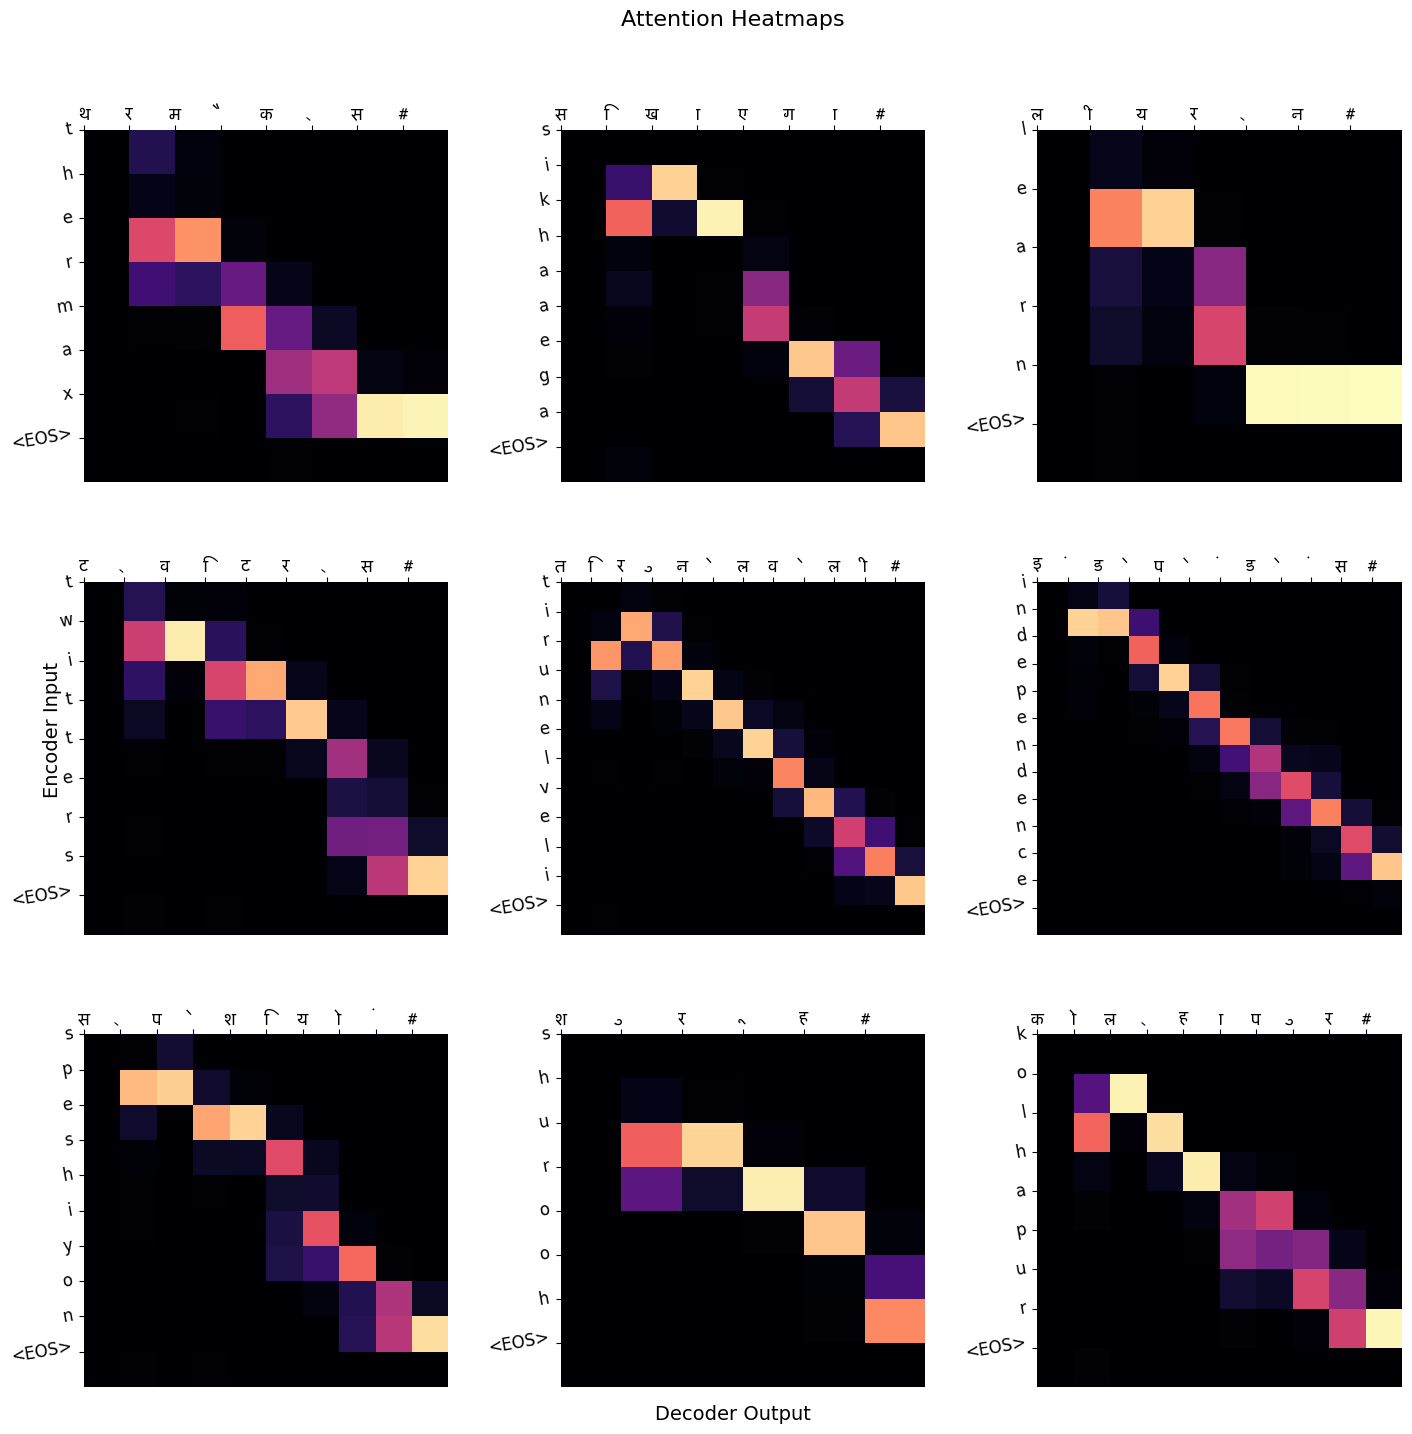

In [20]:
#code for attention map starts
import seaborn as sns
print(vocab.source_idx_to_char)
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
with torch.no_grad():
        for i, (input_seq, target_seq) in enumerate(test_dataloader):
            inp_data = input_seq.to(device)
            tar = target_seq.to(device)
            x=inp_data.shape[0]
            y=tar.shape[0]
            # Forward prop
            outputs,attention_weight = model(inp_data, tar, teacher_force_ratio=0.0)
            
            output = outputs[1:]
            preds = output.argmax(dim=2)
            attentionn_matrix = attention_weight[1:]
            
            attentionn_matrix = attention_weight.permute(1, 0, 2)
            inp_data = inp_data.T
            preds = preds.T
            
            attn_matrix=attentionn_matrix
            
            
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))
            fig.text(0.5, 0.04, 'Decoder Output', ha='center', size=14)
            fig.text(0.04, 0.5, 'Encoder Input', va='center', rotation='vertical', size=14)
            fig.suptitle("Attention Heatmaps", fontsize=16)
            fig.tight_layout(pad=5.0)
            fig.subplots_adjust(top=0.90)

            font_prop = FontProperties(fname='/kaggle/input/mangal-font/Mangal.TTF')

            axes = axes.ravel()
            for i, (input_seq_i, pred_seq_i) in enumerate(zip(inp_data, preds)):
                src_len = (input_seq_i == 1).nonzero(as_tuple=False).item() + 1 if 1 in input_seq_i else x
                pred_len = (pred_seq_i == 1).nonzero(as_tuple=False).item() + 1 if 1 in pred_seq_i else y - 1

                local_attn = attn_matrix[i, :pred_len, :src_len].T.cpu()

                xticklabels = [vocab.target_idx_to_char[idx.item()] for idx in pred_seq_i[:pred_len]]
                xticklabels[-1] = "#"
                yticklabels = [vocab.source_idx_to_char[idx.item()] for idx in input_seq_i[:src_len]]

                sns.heatmap(local_attn, ax=axes[i], cmap='magma', cbar=False, vmin=0.0, vmax=1.0)
                axes[i].set(xticks=range(pred_len), yticks=range(src_len))
                axes[i].set_yticklabels(yticklabels, rotation=10, fontdict={'fontsize': 12})  
                axes[i].set_xticklabels(xticklabels, fontproperties=font_prop, fontdict={'fontsize': 12})
                axes[i].xaxis.tick_top()

            plt.savefig('/kaggle/working/attn_hmap.png')
            wandb.init(project="heatmap1")
            wandb.log({'Attention Heatmap': wandb.Image(fig)})
            wandb.finish()
            break
            

#code for attention map ends